<a href="https://colab.research.google.com/github/tlysenko/ML-notebooks/blob/master/Clinical_Trials_in_Ukraine_2012_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The task

По ссылке — таблица с данными о клинических исследованиях (КИ), проведенными в Украине с 2002 по 2018. На основе таблицы рассчитайте 3 вида статистических показателей, которые, на ваш взгляд, наиболее точно отражают ситуацию с КИ в Украине, и сделайте выводы. Опишите ход рассуждений и укажите источники, которыми вы руководствовались при выборе показателей. Прикрепите xls с расчетами и формулами. 

## Installing the libraries

In [2]:
# Installing the libraries
!pip install transliterate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.0 MB/s 


In [3]:
# Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from transliterate import translit

## Helper functions

In [4]:
# list the regions 
def translit_ua_to_lat(line):
  return translit(line,'ru',reversed=True).replace("'","")

def unique_values_from_rows_to_set(df_column):
  my_set = set()
  for row in df_column:
    [my_set.add(x.strip()) for x in row.split('|')]
  return my_set

## Reading the spreadsheets

In [ ]:
# Connecting to GoogleDrive 

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [158]:
###
### Read the original spreadsheet (copied to my GoogleDrive )
### 

worksheet = gc.open('Ukrainian_clinical_trials').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
df1 = pd.DataFrame.from_records(rows)

# Set first row as a header
df1.columns = df1.iloc[0] 
df1 = df1[1:]


# Transliterate colum names
translit_cols = []
for col in df1.columns:
   df1.rename(columns={col : 
                      translit_ua_to_lat(col) }, 
                      inplace=True)  
   
###
### Read the full database of clinical trials copied from https://clinicaltrials.dec.gov.ua and saved locally 
### 

worksheet = gc.open('scrapped_db_ci').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
df2 = pd.DataFrame.from_records(rows)

# Set first row as a header
df2.columns = df2.iloc[0] 
df2 = df2[1:]


# Transliterate colum names
translit_cols = []
for col in df2.columns:
   df2.rename(columns={col : 
                      translit_ua_to_lat(col) }, 
                      inplace=True)  

df2.rename(columns={'Kod KV': 'Kod'}, inplace = True)
df2.rename(columns={'Data pochatku KV v Ukraїnі': 'Startdate'}, inplace = True)

In [159]:
# Merging the dataframes
df3 = df1.set_index('Kod').join(df2[['Kod', 'Startdate']].set_index('Kod'))

## Data Cleaning

In [161]:
# Remove NA
df3['Startdateі']=df3['Startdate'].replace({'':np.NAN})
df3.dropna(inplace=True)

In [162]:
# Adding Year start of the trial
df3['Year'] = [int(x[-4:]) for x in df3['Startdate']]

In [164]:
# Remove NA
df3['Startdateі']=df3['Startdate'].replace({'':np.NAN})
df3.dropna(inplace=True)

df3.drop(df3[df3.Year == 2019].index, inplace=True)

In [ ]:
# % of data lost during the merge and dropna
((df1.shape[0]-df3.shape[0])/df1.shape[0])*100

## EDA

### Condition of the trial

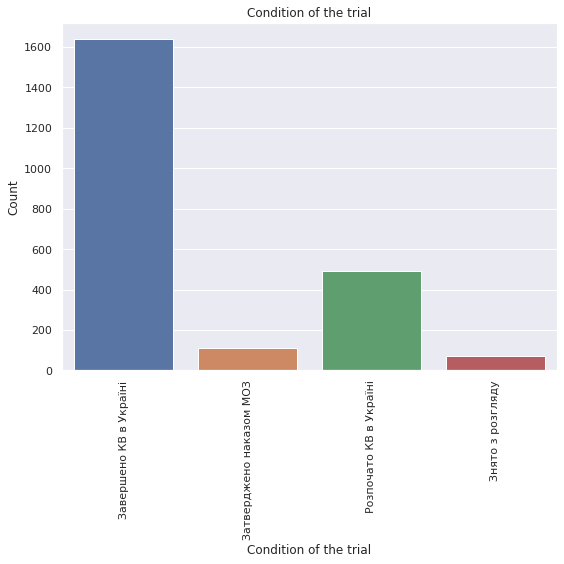

In [37]:
sns.set(rc={'figure.figsize':(8,8)})
sns.countplot(x=df3['Stan']).set(title = 'Condition of the trial',
                                 xlabel = 'Condition of the trial',
                                 ylabel = 'Count')

plt.xticks(rotation=90)
plt.tight_layout();

In [16]:
np.round(df3['Stan'].value_counts(normalize=True, ascending=False, sort = True)*100)

Завершено КВ в Україні     71.0
Розпочато КВ в Україні     21.0
Затверджено наказом МОЗ     5.0
Знято з розгляду            3.0
Name: Stan, dtype: float64

In [18]:
df3['Stan'].value_counts(normalize=False)

Завершено КВ в Україні     1638
Розпочато КВ в Україні      493
Затверджено наказом МОЗ     110
Знято з розгляду             70
Name: Stan, dtype: int64

**The main question is why most of the trials are over ?** 


### Phase of the trial

In [23]:
# We can see that the data or phases are rather noisy
df3['Fazi'].value_counts(normalize=True)*100

3             56.815232
2             22.457810
Інша          10.817828
1              3.072263
4              2.942449
2, 3           1.860666
1, 2           0.692341
3, 4           0.346170
Інша, 1        0.302899
Інша, 3        0.216357
Інша, 1, 2     0.129814
1, 3           0.086543
Інша, 2        0.086543
Інша, 1, 3     0.086543
Інша, 4        0.043271
2, 4           0.043271
Name: Fazi, dtype: float64

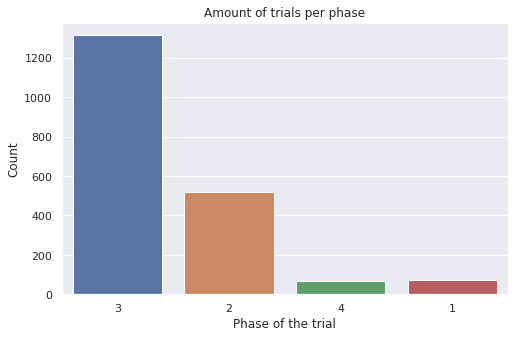

In [32]:
sns.set(rc={'figure.figsize':(8,5)})
sns.countplot(x = df3['Fazi'][df3['Fazi'].isin(['1','2','3','4'])]).set(title='Amount of trials per phase',
                                                                        xlabel='Phase of the trial',
                                                                        ylabel ='Count');

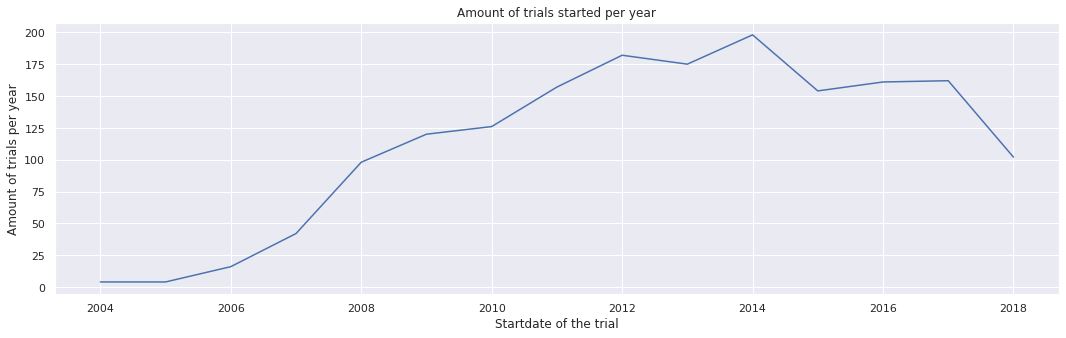

In [183]:
sns.set(rc={'figure.figsize':(18,5)})
df4 = pd.DataFrame(df3['Year'].value_counts(ascending=False))
sns.lineplot(data = df4, x=df4.index, y='Year').set(title='Amount of trials started per year',
                                                    xlabel = 'Startdate of the trial',
                                                    ylabel = 'Amount of trials per year');

## Analytical summary 

In [190]:
"Общее количество КИ в период с 2002 по 2018 составляет {} исследований. Самая большая доля клинических исследований выпадает на категорию \"{}\" и \
составляет {}% и {} исследований. Значительная доля всех исследований ({} процент) исследований находится в состоянии \"{}\", что вызывает больше всего вопросов. \
Судя по динамике мы видим, что количество новых КИ росло до 2014 года и пошло на спад после 2014 года. Можно сделать вывод, что начало военных действией \
в Крыму и на Донбассе повлияли на снижение количества новых в КИ в Украине. Эта же ситуация повторяется в 2022 году с началом полномасштабной войны в Украине.".format(
    
    # Total amount 
    df1['Kod'].nunique(),
    # Max category 
    df3['Medichnij naprjam'].value_counts(normalize=True, ascending=False, sort = True).index[0],
    np.round(df3['Medichnij naprjam'].value_counts(normalize=True, ascending=False, sort = True)[0]*100),
    df3['Medichnij naprjam'].value_counts(normalize=False).max(),
    
    # Max status
    np.round(df3['Stan'].value_counts(normalize=True, ascending=False, sort = True)[0]*100),
    df3['Stan'].value_counts(normalize=True, ascending=False, sort = True).index[0]
    
    )

'Общее количество КИ в период с 2002 по 2018 составляет 2308 исследований. Самая большая доля клинических исследований выпадает на категорию "Онкологія" и составляет 15.0% и 255 исследований. Значительная доля всех исследований (78.0 процент) исследований находится в состоянии "Завершено КВ в Україні", что вызывает больше всего вопросов. Судя по динамике мы видим, что количество новых КИ росло до 2014 года и пошло на спад после 2014 года. Можно сделать вывод, что начало военных действией в Крыму и на Донбассе повлияли на снижение количества новых в КИ в Украине. Эта же ситуация повторяется в 2022 году с началом полномасштабной войны в Украине.'